<a href="https://colab.research.google.com/github/evillag/TEC-ML-2022-1/blob/main/TP3/TP3_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Aprendizaje Automático
# Trabajo Practico 3: Implementación del algoritmo K-medias
**Escuela de Ingeniería en Computación | Instituto Tecnológico de Costa Rica**

Realizado por
*   Luis Badilla Ortiz
*   William Jiménez García
*   Esteban Villalobos Gómez

Fecha de entrega
*  31 de mayo del 2022

Entrega
* Un archivo .zip con el código fuente LaTeX o Lyx, el pdf, y un notebook en jupyter, debidamente documentado, con una función definida por ejercicio. A través del TEC-digital.

Modo de trabajo
* Grupos de 3 personas.

# Imports

In [ ]:
import torch
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_moons

# Data creation

In [ ]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [26, 26], stds1 = [3, 3, 2, 2], stds2 = [2, 2, 1, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation[0,1] and covariance[2,3] for samples, class 1
    @param stds2, standard deviation[0,1] and covariance[2,3] for samples, class 2    
    """
    # Create Data Class 1
    covarianceMatrix = torch.tensor([[stds1[0], stds1[2]], 
                                     [stds1[3], stds1[1]]]).float()
    samplesClass1 = createDataOneClass(torch.tensor(mean1).float(), covarianceMatrix, numberSamplesPerClass)
    
    # Create Data Class 2
    covarianceMatrix = torch.tensor([[stds2[0], stds2[2]], 
                                     [stds2[3], stds2[1]]]).float()
    samplesClass2 = createDataOneClass(torch.tensor(mean2).float(), covarianceMatrix, numberSamplesPerClass)

    #Contatenate all samples
    samplesAll = torch.cat((samplesClass1, samplesClass2), 1)
    
    #Create targets
    targetsClass0 = torch.zeros(1, numberSamplesPerClass)
    targetsClass1 = torch.ones(1, numberSamplesPerClass)

    #Contatenate all targets
    targetsAll = torch.cat((targetsClass0, targetsClass1), 1)[0]
    
    return (targetsAll, samplesAll)

def createDataOneClass(means, covarianceMatrix, numberSamples):
    """
    Creates data with gaussian distribution
    """
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)

    # Create the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples])).T
    return samples

def plotData(dataX, dataY, label="Data", marker="o", show=True, title=""):
    """
    Plot the given data
    """
    plt.scatter(dataX, dataY, label=label, marker=marker)
    plt.legend(loc="upper left")
    plt.title(title)
    if(show):
      plt.show()
  
def plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=""):
    """
    Plot data by class or whole data
    """
    if(show_separated):
      # Show data with labels and symbols
      DataClass0 = SamplesAll[:, TargetsAll==0]
      DataClass1 = SamplesAll[:, TargetsAll==1]
      plotData(DataClass0[0], DataClass0[1], label="Class 1 Samples", marker="x", show=False)
      plotData(DataClass1[0], DataClass1[1], label="Class 2 Samples", show=show_plot, title=title)
    else:
      # Show whole data without labels and symbols
      plotData(SamplesAll[0], SamplesAll[1], label="Samples", show=show_plot, title=title)


def plotError(loss_arr, title='Training Error'):
  fig = plt.figure()    
  plt.xlabel("Iteration")
  plt.ylabel("Error %")
  plt.title(title)
  plt.plot(loss_arr)
  plt.show()
  fig.clear()

# Punto: 1.1.a.1 - Easy separation Data

In [ ]:
# Easy separation Data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,10], mean2 = [25, 10], stds1 = [10, 10, 9, 9], stds2 = [9, 9, -8.5, -8.5]) 

# Punto: 1.1.b - Plot Data

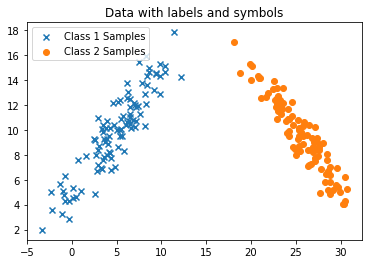

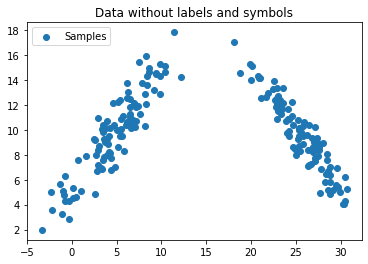

In [ ]:
# Show data with labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=True, title="Data with labels and symbols")

# Show whole data without labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=False, title="Data without labels and symbols")

# Punto: 1.1.a.2 - Hard separation data

In [ ]:
# Hard separation data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [15,15], mean2 = [27, 15], stds1 = [20, 20, 19, 19], stds2 = [19, 19, -17, -17]) 

# Punto: 1.1.b - Plot Data

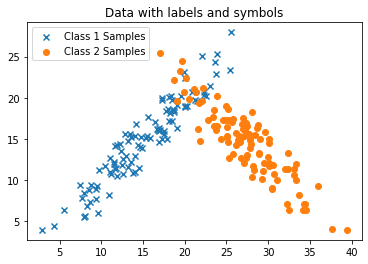

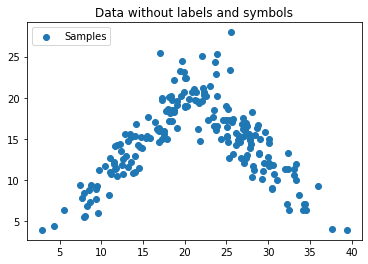

In [ ]:
# Show data with labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=True, title="Data with labels and symbols")

# Show whole data without labels and symbols
plotSampleData(SamplesAll, TargetsAll, show_separated=False, title="Data without labels and symbols")

# Punto 1.2 - Implement K_Means algorithm

In [ ]:
def predict(W):
  predicted = torch.ones(W.shape[0])
  predicted[W[:, 0] == 1] = 0
  return predicted


def Test_K_Means(W, targets=TargetsAll):

  predicted = predict(W)
  prediction1 = predicted == targets
  prediction2 = predicted != targets

  total = torch.max(torch.count_nonzero(prediction1), torch.count_nonzero(prediction2))
  cant = targets.shape[0]
  accuracy = round((total / cant * 100).item(), 5)

  return accuracy


def Train_K_Means(iterations=10, euclidean=True, show_plot=False):
  """
  Implementation of the K_Means algorithm
  It was implemented only using matrix operations
  @param iterations, the maximum number of iterations
  @param euclidean, defines if use L2 or L1 distance 
  """
  allLosses = []
  
  # STEP 1: Initilize Means randomly
  Means = torch.rand(2, 2)
  Means_bck = torch.zeros(2, 2)

  # Get rows and cols size
  rows, cols = SamplesAll.shape
  
  # P = 1 to Manhattan distance
  # P = 2 to Euclidean distance
  P = 2 if euclidean else 1

  for iteration in range(iterations):
    #print(f'================== Iteration: {iteration + 1} ==================')
    #print('Means:', Means)

    # Avoid continue if means didn't change
    if((Means != Means_bck).count_nonzero().item() == 0):
      #print("Attention: Means didn't change, stopping process")
      break
    else:
      Means_bck = Means.clone()
    
    if(show_plot):
      # Plot the proccess
      plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=False)
      plotData(Means[0], Means[1], label="Means", marker='s') # Show means position

    # STEP 2.A: LABELING SAMPLES
    # Get the distance to first mean
    distance1stMean = torch.norm(SamplesAll.T - Means[:, 0], P, dim=1)

    # Get the distance to second mean
    distance2ndMean = torch.norm(SamplesAll.T - Means[:, 1], P, dim=1)

    # Choose minimum distance to means for each sample
    minMatrix = torch.min(distance1stMean, distance2ndMean)

    # STEP 2.B: MINIMIZING ERROR FUNCTION
    # Create W Matrix
    W = torch.cat(((minMatrix == distance1stMean).view(cols,1), (minMatrix == distance2ndMean).view(cols,1)), dim=1).float()

    # Count elements in each class 
    class0Qty = torch.sum(W[:, 0])
    class1Qty = torch.sum(W[:, 1])

    class0Qty = class0Qty if class0Qty != 0 else 1 # To avoid zero division
    class1Qty = class1Qty if class1Qty != 0 else 1 # To avoid zero division
    
    # Calc new Means
    Means[:, 0] = W[:, 0].view(1, cols).mm(SamplesAll.T) / class0Qty
    Means[:, 1] = W[:, 1].view(1, cols).mm(SamplesAll.T) / class1Qty
    

    # This is not required for training, it is only used to plot the loss later
    allLosses.append(100.0 - Test_K_Means(W))

  # STEP 3: MATRIX W TO PREDICT LABELS
  return W, allLosses


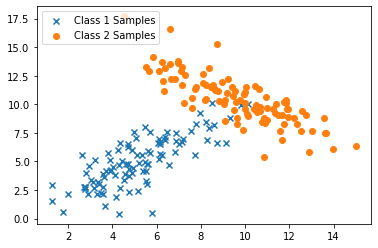

In [ ]:
# Create Data
(TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,5], mean2 = [10, 10], stds1 = [5, 5, 4.2, 4.2], stds2 = [6, 6, -5, -5]) 
plotSampleData(SamplesAll, TargetsAll, show_separated=True)

# Punto 1.2.a Using Euclidean distance

In [ ]:
# Train W Matrix
W, allLosses = Train_K_Means(euclidean=True, show_plot=False)

# Calc Accuracy
accuracy = Test_K_Means(W, TargetsAll)

plotError(allLosses, "Euclidean Distance Training error")
print(f'\nAccuracy: {accuracy} %')

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1

RuntimeError: ignored

# Punto 1.2.b Using Manhattan Distance

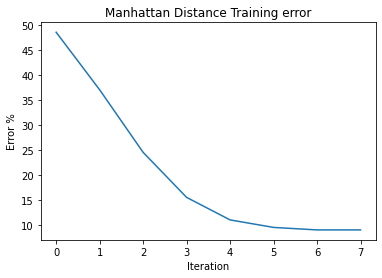


Accuracy: 91.0 %


In [ ]:
# Train W Matrix
W, allLosses = Train_K_Means(euclidean=False, show_plot=False)

# Calc Accuracy
accuracy = Test_K_Means(W, TargetsAll)

plotError(allLosses, "Manhattan Distance Training error")
print(f'\nAccuracy: {accuracy} %')

# Punto 1.2.c Results


================== Iteration: 1 ==================



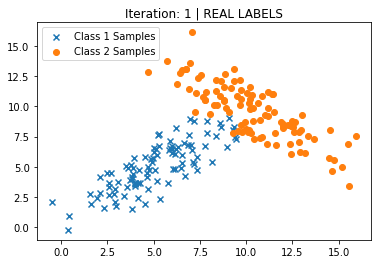

-----------------------------------------------


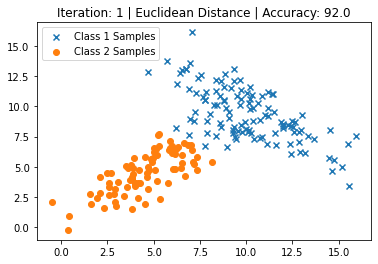

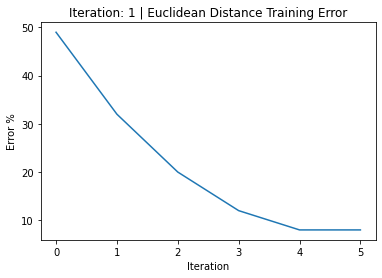

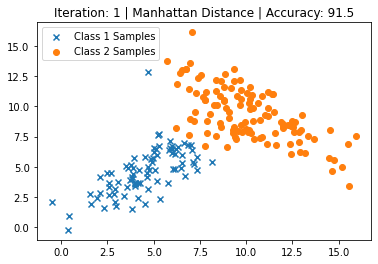

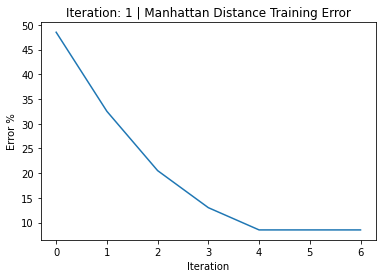


================== Iteration: 2 ==================



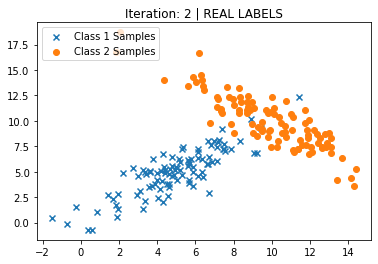

-----------------------------------------------


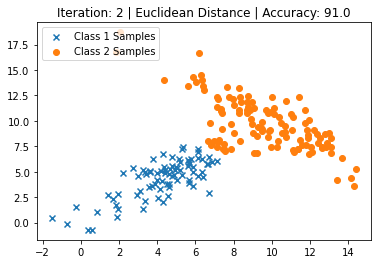

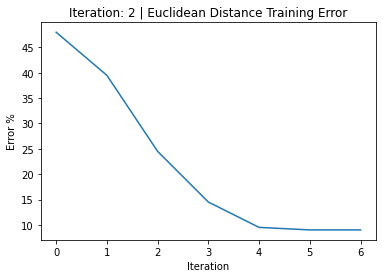

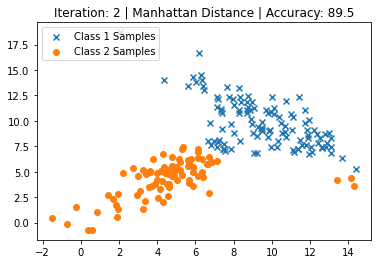

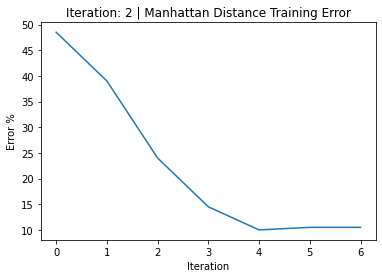


================== Iteration: 3 ==================



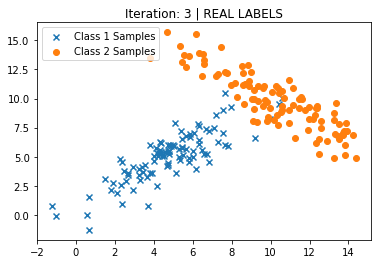

-----------------------------------------------


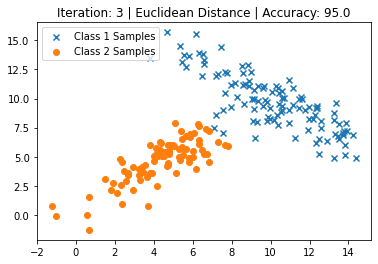

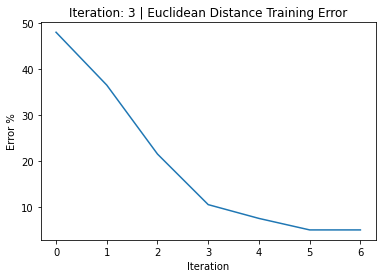

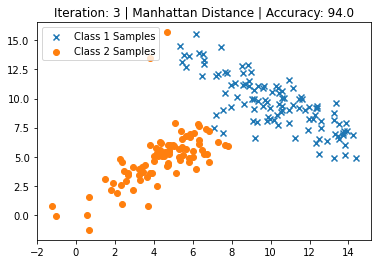

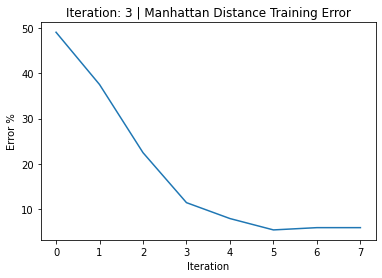


================== Iteration: 4 ==================



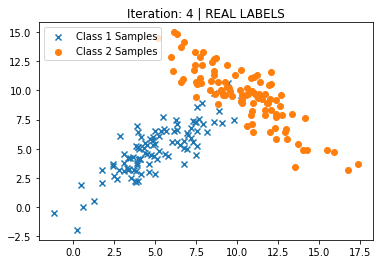

-----------------------------------------------


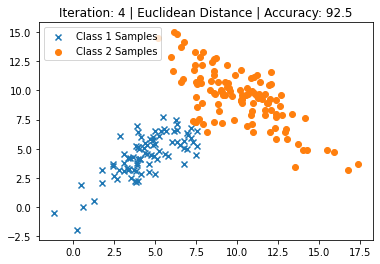

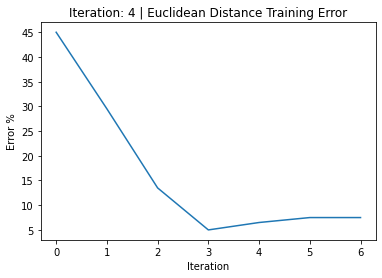

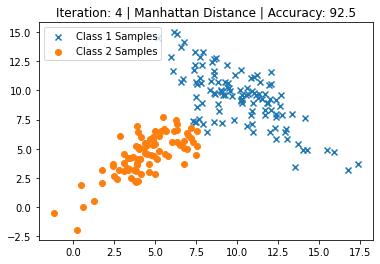

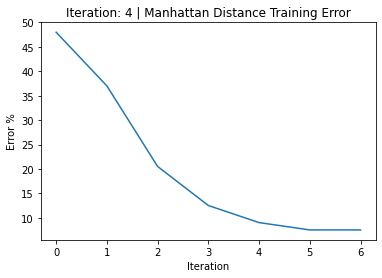


================== Iteration: 5 ==================



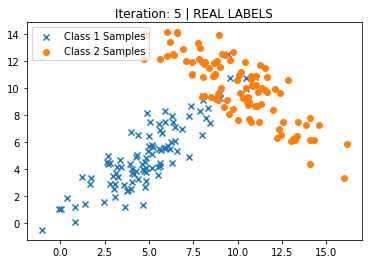

-----------------------------------------------


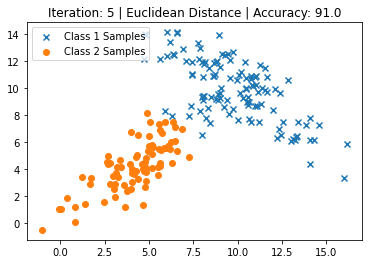

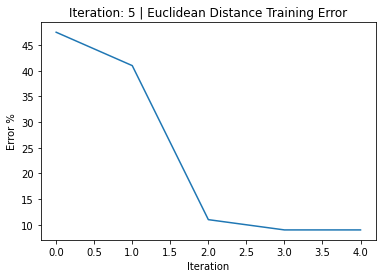

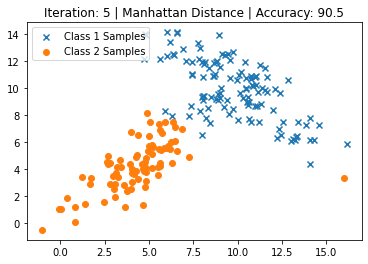

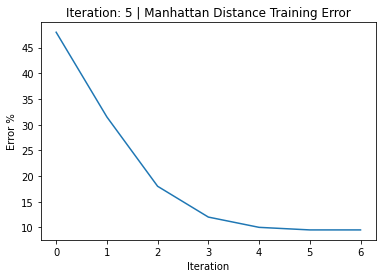


================== Iteration: 6 ==================



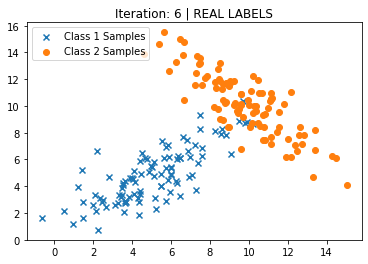

-----------------------------------------------


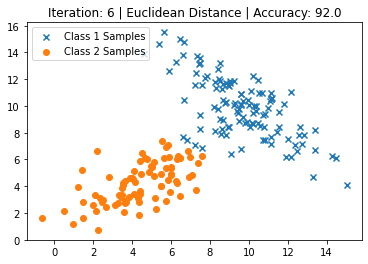

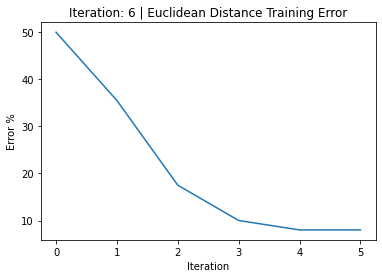

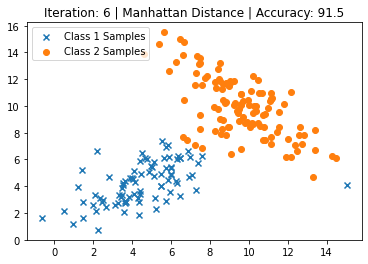

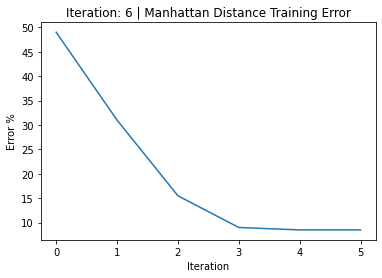


================== Iteration: 7 ==================



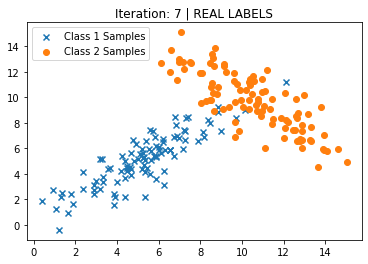

-----------------------------------------------


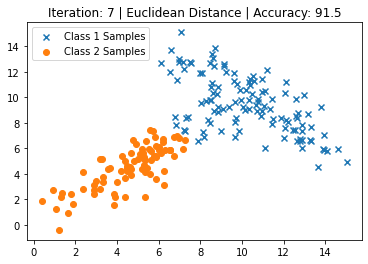

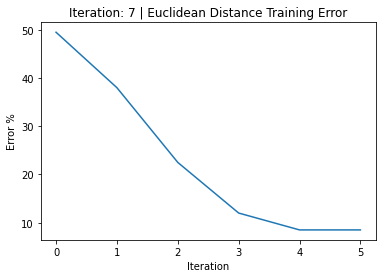

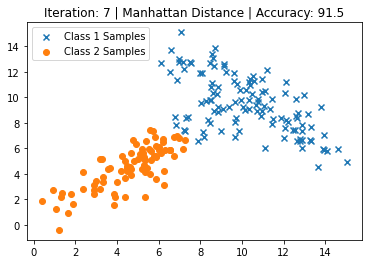

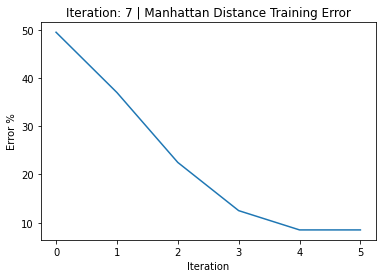


================== Iteration: 8 ==================



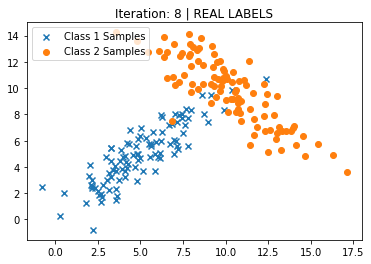

-----------------------------------------------


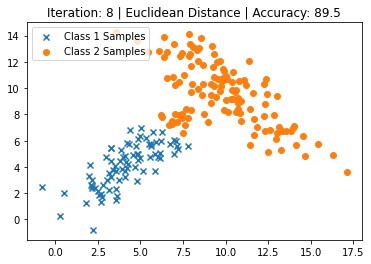

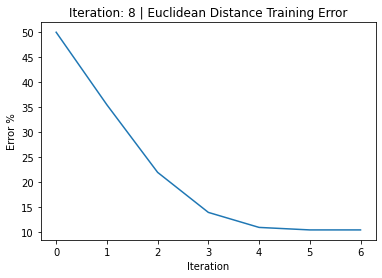

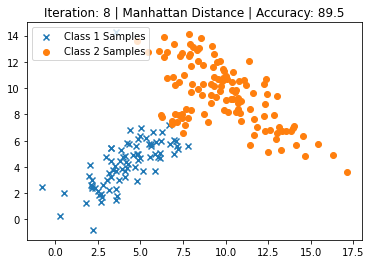

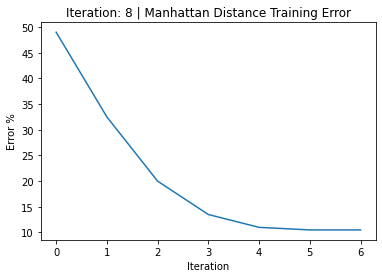


================== Iteration: 9 ==================



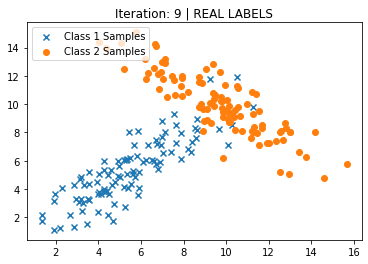

-----------------------------------------------


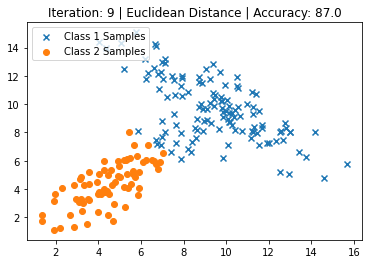

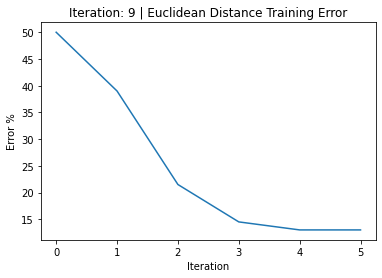

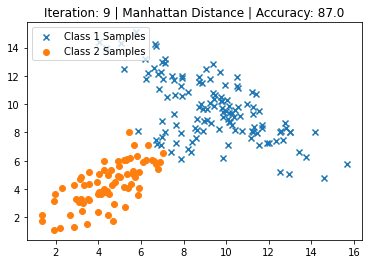

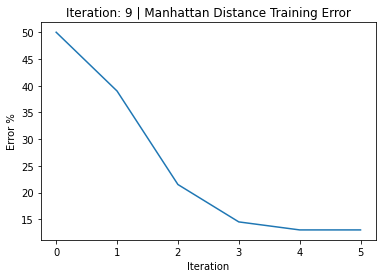


================== Iteration: 10 ==================



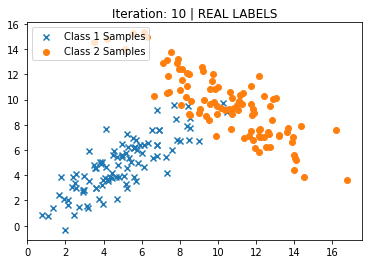

-----------------------------------------------


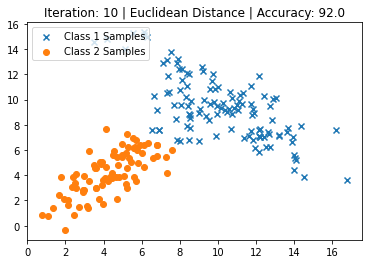

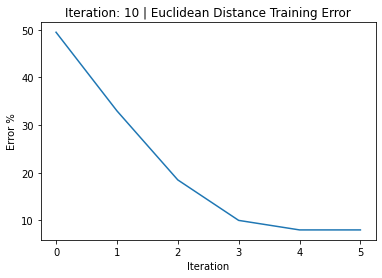

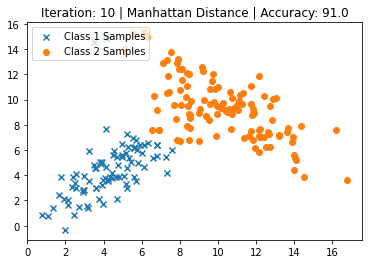

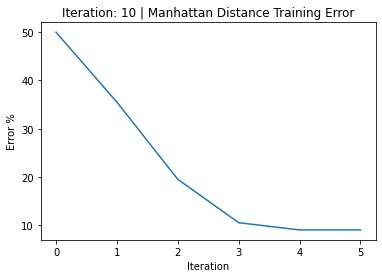


EUCLIDEAN DISTANCE
== Accuracy ==
Std: 2.069
Mean: 91.35
== Time ==
Std: 0.001
Mean: 0.005

MANHATTAN DISTANCE
== Accuracy ==
Std: 1.901
Mean: 90.85
== Time ==
Std: 0.0
Mean: 0.003


In [ ]:
# Number of iterations
iterations = 10

# To save accuraccies
accuracies = torch.zeros(2, iterations)

# To save times
times = torch.zeros(2, iterations)

for iteration in range(iterations):
  print(f'\n================== Iteration: {iteration + 1} ==================\n')
  
  # Create Data
  (TargetsAll, SamplesAll) = createData(numberSamplesPerClass = 100, mean1 = [5,5], mean2 = [10, 10], stds1 = [5, 5, 4.2, 4.2], stds2 = [6, 6, -5, -5]) 

  # Plot real data
  plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | REAL LABELS")

  # == EUCLIDEAN DISTANCE == #
  # Train W Matrix Using: [Euclidean Distance]
  start_time = time.time()
  W, allLosses = Train_K_Means(euclidean=True, show_plot=False)
  times[0][iteration] = time.time() - start_time
  print("-----------------------------------------------")
  # Calc Accuracy
  accuracies[0][iteration] = Test_K_Means(W, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Euclidean Distance | Accuracy: {accuracies[0][iteration]}")
  plotError(allLosses, f"Iteration: {iteration + 1} | Euclidean Distance Training Error")
  # == EUCLIDEAN DISTANCE == #

  # == MANHATTAN DISTANCE == #
  # Train W Matrix Using: [Manhattan Distance]
  start_time = time.time()
  W, allLosses = Train_K_Means(euclidean=False, show_plot=False)
  times[1][iteration] = time.time() - start_time

  # Calc Accuracy
  accuracies[1][iteration] = Test_K_Means(W, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predict(W), show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Manhattan Distance | Accuracy: {accuracies[1][iteration]}")
  plotError(allLosses, f"Iteration: {iteration + 1} | Manhattan Distance Training Error")
  # == MANHATTAN DISTANCE == #

print("\nEUCLIDEAN DISTANCE")
print("== Accuracy ==")
print("Std:", round(accuracies[0].std().item(), 3))
print("Mean:", round(accuracies[0].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[0].std().item(), 3))
print("Mean:", round(times[0].mean().item(), 3))

print("\nMANHATTAN DISTANCE")
print("== Accuracy ==")
print("Std:", round(accuracies[1].std().item(), 3))
print("Mean:", round(accuracies[1].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[1].std().item(), 3))
print("Mean:", round(times[1].mean().item(), 3))

### Evaluación de resultados

Se realizaron 10 corridas con cada una de las distancias para el algoritmo de K-medias, y los resultados obtenidos se detallan en la tabla a continuación.

| Corrida | Euclidean | Manhattan |
|---------|--------|--------|
|    1    |    90.5| 90.5   |
|    2    | 93.5 | 93.0 |
|    3    | 96.5 | 96.0 |
|    4    | 92.5 | 92.0 |
|    5    | 91.0 | 91.0 |
|    6    | 88.0 | 86.5 |
|    7    | 97.0 | 95.5 |
|    8    | 90.0 | 90.0 |
|    9    | 93.5 | 93.0 |
|   10    | 91.0 | 90.5 |
| Media   | 92.35 | 91.8 |
| S.D.    | 2.848 | 2.781 |
|Tiempo Prom| 0.006 | 0.003 |
|Tiempo SD| 0.001 | 0.001 |

# 2.1 Implementación Corte de grafos

In [ ]:
# Binary Tree data structure
class NodeV1:
  def __init__(self, data):
      
    self.left = None
    self.left_edge = 0.0
    self.right = None
    self.right_edge = 0.0
    self.vertex = data

  def find(self, v):
    if self.vertex == v:
      return self
    
    node = None
    if self.left:
      node = self.left.find(v)
    if node is None and self.right:
      node = self.right.find(v)
    return node

  def add(self, vertex, edge):
    if self.left is None:
      self.left = Node(vertex)
      self.left_edge = edge
    elif self.right is None:
      self.right = Node(vertex)
      self.right_edge = edge
    elif edge < self.left_edge:
      self.left.add(vertex, edge)
    else:
      self.right.add(vertex, edge)

  def get_vertices(self):
    vertices = [self.vertex]
    left_vertices = []
    right_vertices = []
    if self.left:
      left_vertices = self.left.get_vertices()
    if self.right:
      right_vertices = self.right.get_vertices()
    return vertices + left_vertices + right_vertices

  def _get_max(self):
    if self.left_edge > self.right_edge:
      return self.left_edge, self.left
    else:
      return self.right_edge, self.right

  def cut(self):
    max_edge, max_node = self._get_max()
    tmp_edge = 0.0
    tmp_node = None
    if self.left:
      tmp_edge, tmp_node = self.left.cut()
      if tmp_edge > max_edge:
        max_edge = tmp_edge
        max_node = tmp_node
    if self.right:
      tmp_edge, tmp_node = self.right.cut()
      if tmp_edge > max_edge:
        max_edge = tmp_edge
        max_node = tmp_node
    return max_edge, max_node

  def __str__(self):
    if self.left is None and self.right is None:
      s = f'<node leaf="true">{self.vertex}'
    else:
      s = f'<node>{self.vertex}'

    if self.left:
      s += f'{str(self.left)}<weight>{self.left_edge}</weight>'
    if self.right:
      s += f'{str(self.right)}<weight>{self.right_edge}</weight>'
    s += '</node>'
    return s

In [ ]:
class _Edge:
  def __init__(self, node, weight):
    self.node = node
    self.weight = weight

# N-ary Tree data structure
class NodeV2:

  def __init__(self, vertex):
    self.edges = []
    self.vertex = vertex

  def find(self, v):
    node = None
    if self.vertex == v:
      return self
    for edge in self.edges:
      if edge.node.vertex == v:
        return edge.node
      node = edge.node.find(v)
      if node:
        return node
    
  def add(self, from_vertex, to_vertex, weight):
    from_node = self.find(from_vertex)
    if from_node is None:
      return False
    from_node.edges.append(_Edge(Node(to_vertex), weight))
    return True

  def get_vertices(self):
    vertices = [self.vertex]
    for edge in self.edges:
      vertices += edge.node.get_vertices()
    return vertices

  def _get_max_edge(self):
    max_edge = None
    for edge in self.edges:
      if max_edge is None or max_edge.weight < edge.weight:
        max_edge = edge

      candidate_max_edge = edge.node._get_max_edge()
      if candidate_max_edge and max_edge.weight < candidate_max_edge.weight:
        max_edge = candidate_max_edge
    return max_edge

  def cut(self):
    max_edge = self._get_max_edge()
    return max_edge.weight, max_edge.node

  def __str__(self):
    if not self.edges:
      s = f'<node leaf="true">{self.vertex}'
    else:
      s = f'<node>{self.vertex}'
    for edge in self.edges:
      s += f'{str(edge.node)}<weight>{edge.weight}</weight>'
    s += '</node>'
    return s


In [ ]:
import random

Node = NodeV2

def train_graph(samples=SamplesAll):
  # Generate Edges matrix with Eculidean distance between vertices
  edges = torch.cdist(samples.T, samples.T)

  # Initialize two sets, over which the tree will be constructed. 
  a = []
  b = [i for i in range(samples.shape[1])]

  v = random.choice(b)
  b.remove(v)
  a.append(v)
  tree = Node(v)

  while(len(b)):  
    # busco el camino mas corto de B a algun nodo en A
    from_vertex = -1
    min_edge = 999999999.0
    min_vertex = -1
    
    for v in a:
      # print(f'testing {v}, a={a}, b={b}')
      min_node = edges[v, b].topk(1, largest=False)
      min_node_vertex = b[min_node.indices[0].item()]
      min_node_edge = min_node.values[0].item()
      if min_node_edge < min_edge:
        # print(f'new min! {v} -> {min_node_vertex}: {min_node_edge}')
        from_vertex = v
        min_edge = min_node_edge
        min_vertex = min_node_vertex
    
    # print(f'{from_vertex} -> {min_vertex}: {min_edge}')
    # tree.find(from_vertex).add(min_vertex, min_edge) #  uncomment for NodeV1
    added = tree.add(from_vertex, min_vertex, min_edge)  # uncomment for NodeV2
    if not added:
      print("Error building tree")
    a.append(min_vertex)
    b.remove(min_vertex)
  
  # print(f'Tree: {tree}')
  return tree

In [ ]:
def predict_graph(model):
  predicted = torch.zeros(TargetsAll.shape)
  w, class_one_node = model.cut()
  class_one_vertices = class_one_node.get_vertices()
  predicted[class_one_vertices] = 1
  print(f'Cut node: {class_one_node.vertex}, weight: {w}, vertices {class_one_vertices}')
  return predicted

def test_graph_cut(predicted, targets=TargetsAll):
  prediction1 = predicted == targets
  prediction2 = predicted != targets

  total = torch.max(torch.count_nonzero(prediction1), torch.count_nonzero(prediction2))
  cant = targets.shape[0]
  accuracy = round((total / cant * 100).item(), 5)

  return accuracy
  

#2.2 Generación de dos medias lunas

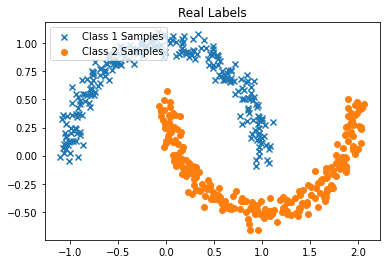

<node>155<node>113<node>339<node>76<node>223<node>33<node>354<node leaf="true">61</node><weight>0.017578125</weight></node><weight>0.0089902114123106</weight></node><weight>0.018020158633589745</weight></node><weight>0.04182863608002663</weight></node><weight>0.04109402373433113</weight><node>109<node>135<node>377<node>460<node>437<node>178<node>471<node>334<node>303<node>214<node>26<node>330<node>57<node>352<node leaf="true">71</node><weight>0.07231509685516357</weight></node><weight>0.02037367783486843</weight></node><weight>0.04149959608912468</weight><node>265<node>173<node>231<node>361<node leaf="true">190</node><weight>0.024203190580010414</weight></node><weight>0.010669811628758907</weight><node>408<node>384<node>452<node>337<node>120<node>211<node>110<node leaf="true">421</node><weight>0.013099686242640018</weight></node><weight>0.024702882394194603</weight></node><weight>0.018687525764107704</weight><node>31<node>251<node leaf="true">268</node><weight>0.03373207151889801</weig

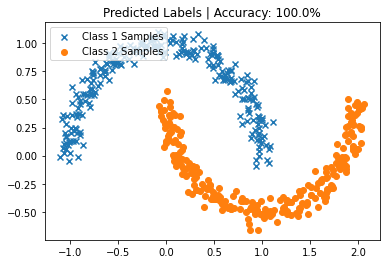

In [ ]:
# TargetsAll, SamplesAll = createData(numberSamplesPerClass = 100, mean1 = [5,5], mean2 = [10, 10], stds1 = [5, 5, 4.2, 4.2], stds2 = [6, 6, -5, -5])
# plotSampleData(SamplesAll, TargetsAll, title='Real Labels')
x, y = make_moons(n_samples= 500, noise= 0.06)
TargetsAll = torch.tensor(y, dtype=torch.float)
SamplesAll = torch.tensor(x, dtype=torch.float).T
plotSampleData(SamplesAll, TargetsAll, title='Real Labels')

model = train_graph(SamplesAll)
print(model)
predicted_labels = predict_graph(model)
accuracy = test_graph_cut(predicted_labels, TargetsAll)
plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Predicted Labels | Accuracy: {accuracy}%")


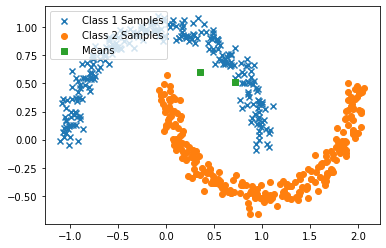

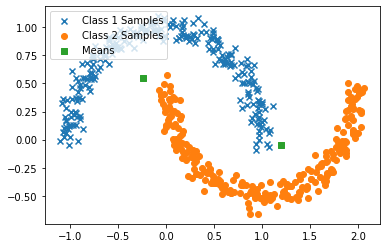

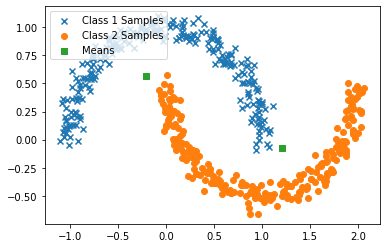

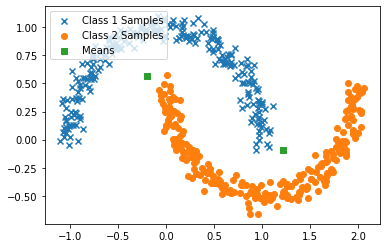

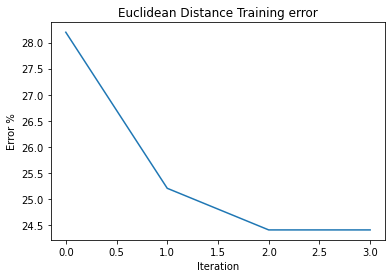


Accuracy: 75.6 %


In [ ]:
# Train W Matrix
W, allLosses = Train_K_Means(euclidean=True, show_plot=True)

# Calc Accuracy
accuracy = Test_K_Means(W, TargetsAll)

plotError(allLosses, "Euclidean Distance Training error")
print(f'\nAccuracy: {accuracy} %')


================== Iteration: 1 ==================



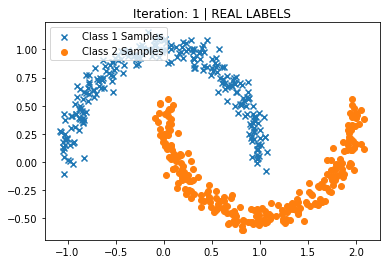

-----------------------------------------------
Cut node: 190, weight: 0.29539480805397034, vertices [190, 364, 377, 242, 108, 427, 375, 128, 3, 130, 496, 129, 313, 361, 403, 458, 164, 266, 102, 221, 421, 196, 94, 105, 324, 184, 121, 197, 270, 409, 308, 226, 348, 258, 162, 211, 74, 372, 444, 29, 115, 278, 54, 332, 469, 238, 86, 418, 394, 55, 210, 487, 254, 2, 182, 234, 493, 257, 45, 358, 399, 404, 250, 330, 49, 240, 389, 139, 392, 287, 176, 207, 414, 481, 212, 142, 463, 225, 58, 312, 382, 371, 81, 106, 299, 406, 112, 494, 477, 288, 275, 269, 67, 251, 17, 63, 310, 76, 28, 441, 439, 328, 159, 23, 125, 327, 474, 413, 319, 398, 426, 260, 408, 77, 178, 26, 32, 111, 366, 145, 144, 109, 320, 492, 381, 466, 114, 452, 127, 161, 384, 233, 150, 412, 246, 25, 245, 119, 386, 473, 367, 204, 249, 167, 235, 107, 460, 124, 305, 165, 322, 274, 373, 8, 292, 216, 455, 433, 311, 97, 353, 424, 72, 126, 232, 78, 291, 41, 390, 202, 92, 440, 24, 199, 224, 283, 405, 391, 110, 70, 491, 62, 66, 206, 215, 277, 351

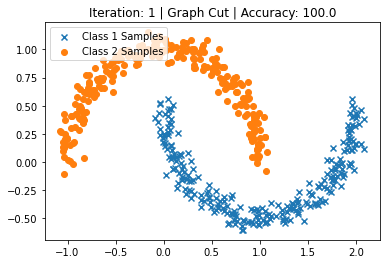


================== Iteration: 2 ==================



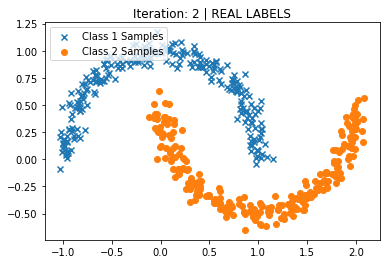

-----------------------------------------------
Cut node: 497, weight: 0.24711349606513977, vertices [497, 351, 235, 387, 219, 365, 38, 53, 250, 84, 401, 88, 486, 300, 352, 104, 438, 105, 18, 480, 241, 130, 90, 323, 251, 129, 378, 176, 217, 417, 361, 461, 44, 183, 335, 225, 407, 415, 145, 356, 449, 395, 413, 65, 220, 293, 247, 132, 80, 482, 292, 196, 3, 191, 79, 469, 283, 4, 140, 40, 396, 347, 392, 362, 290, 308, 398, 184, 110, 437, 222, 166, 460, 211, 165, 349, 116, 409, 495, 372, 374, 152, 278, 468, 231, 498, 189, 146, 263, 325, 187, 433, 423, 233, 15, 230, 279, 439, 267, 131, 474, 360, 6, 270, 147, 475, 102, 440, 264, 272, 68, 488, 427, 463, 208, 320, 384, 434, 394, 11, 477, 10, 101, 85, 479, 261, 224, 344, 27, 37, 277, 117, 441, 302, 285, 5, 126, 92, 41, 406, 425, 82, 143, 57, 128, 364, 61, 253, 416, 58, 493, 177, 215, 154, 244, 355, 138, 276, 391, 142, 125, 419, 258, 245, 149, 412, 133, 326, 144, 281, 188, 124, 197, 139, 353, 357, 13, 193, 491, 333, 404, 388, 123, 207, 162, 119, 2

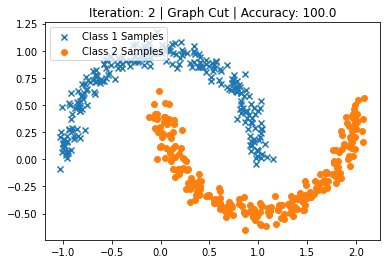


================== Iteration: 3 ==================



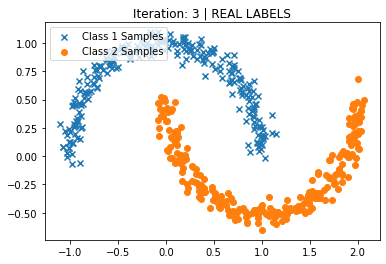

-----------------------------------------------
Cut node: 462, weight: 0.3371751308441162, vertices [462, 56, 478, 25, 20, 297, 361, 129, 51, 77, 143, 75, 71, 107, 250, 202, 429, 55, 316, 331, 497, 415, 151, 225, 126, 49, 365, 146, 373, 104, 392, 276, 469, 79, 252, 166, 98, 386, 236, 369, 42, 150, 116, 449, 182, 158, 432, 15, 215, 290, 491, 257, 165, 85, 0, 197, 475, 12, 343, 125, 163, 467, 224, 72, 185, 10, 255, 205, 80, 5, 287, 266, 422, 30, 192, 124, 13, 213, 277, 486, 388, 149, 54, 114, 451, 323, 267, 139, 256, 364, 464, 216, 498, 220, 228, 196, 480, 269, 442, 341, 66, 404, 168, 29, 477, 214, 346, 247, 157, 483, 97, 200, 398, 229, 227, 339, 362, 212, 430, 485, 292, 296, 39, 306, 164, 308, 78, 190, 64, 437, 108, 87, 333, 380, 311, 389, 177, 338, 43, 186, 463, 26, 242, 47, 490, 271, 426, 103, 11, 278, 381, 121, 358, 117, 172, 382, 328, 22, 335, 379, 161, 326, 241, 395, 176, 408, 237, 394, 411, 152, 261, 52, 141, 119, 8, 194, 291, 38, 34, 414, 94, 413, 259, 76, 246, 286, 401, 31, 376,

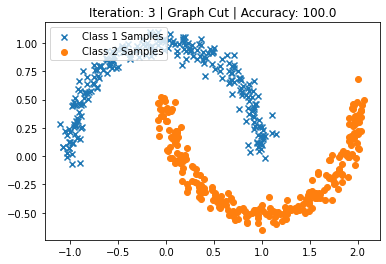


================== Iteration: 4 ==================



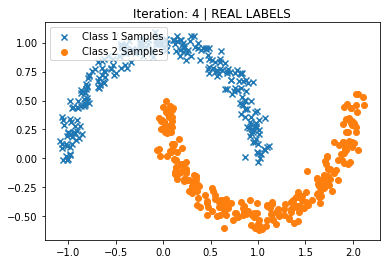

-----------------------------------------------
Cut node: 319, weight: 0.33719170093536377, vertices [319, 208, 250, 42, 252, 15, 30, 178, 297, 399, 333, 335, 452, 220, 291, 482, 158, 160, 325, 320, 40, 237, 438, 433, 432, 496, 226, 448, 57, 20, 238, 383, 477, 75, 373, 361, 457, 416, 273, 67, 107, 201, 490, 386, 189, 334, 129, 174, 142, 51, 455, 101, 374, 155, 207, 112, 249, 236, 437, 246, 349, 456, 184, 52, 144, 235, 384, 58, 306, 80, 231, 114, 300, 264, 341, 74, 43, 73, 132, 239, 35, 131, 412, 262, 138, 484, 443, 175, 364, 492, 410, 29, 308, 223, 63, 313, 428, 332, 8, 97, 298, 230, 39, 99, 441, 218, 495, 36, 229, 71, 256, 407, 164, 368, 181, 253, 289, 274, 315, 5, 206, 171, 10, 420, 275, 12, 475, 23, 419, 390, 467, 156, 211, 426, 168, 127, 53, 55, 163, 166, 157, 367, 391, 331, 241, 499, 77, 195, 330, 395, 460, 284, 7, 370, 240, 287, 200, 24, 431, 406, 462, 197, 445, 466, 295, 41, 45, 375, 213, 61, 449, 172, 37, 470, 351, 430, 145, 366, 89, 147, 422, 418, 117, 227, 85, 242, 268, 464, 

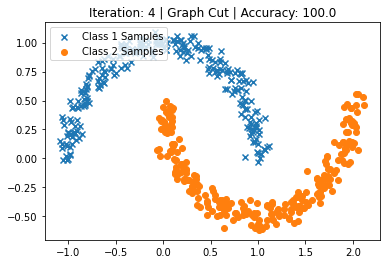


================== Iteration: 5 ==================



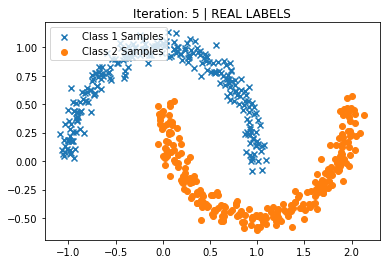

-----------------------------------------------
Cut node: 38, weight: 0.30831238627433777, vertices [38, 228, 215, 401, 80, 436, 433, 321, 76, 12, 411, 170, 409, 294, 399, 347, 152, 496, 149, 112, 428, 345, 264, 417, 303, 435, 389, 199, 337, 209, 248, 488, 467, 305, 205, 405, 48, 52, 308, 310, 211, 86, 103, 190, 479, 183, 22, 122, 156, 106, 184, 499, 398, 120, 301, 282, 451, 62, 469, 242, 278, 117, 43, 374, 439, 108, 351, 27, 150, 304, 246, 158, 224, 131, 302, 235, 174, 140, 90, 177, 289, 486, 221, 273, 194, 344, 410, 316, 244, 397, 447, 395, 164, 155, 37, 169, 180, 60, 432, 343, 191, 28, 94, 33, 475, 47, 419, 391, 193, 111, 167, 168, 329, 331, 8, 162, 250, 232, 141, 446, 58, 175, 457, 1, 335, 277, 470, 208, 227, 237, 115, 265, 96, 100, 445, 473, 361, 356, 70, 10, 110, 358, 126, 492, 441, 42, 252, 478, 139, 101, 63, 299, 15, 196, 173, 186, 444, 251, 16, 460, 145, 230, 325, 240, 332, 59, 298, 68, 468, 225, 3, 159, 418, 462, 357, 364, 116, 406, 257, 85, 485, 442, 368, 113, 82, 400, 438, 

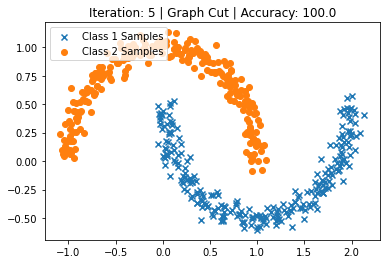


================== Iteration: 6 ==================



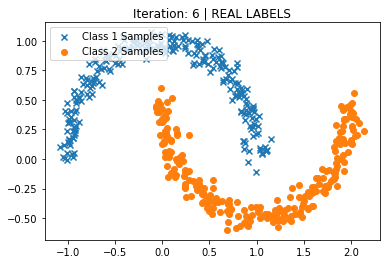

-----------------------------------------------
Cut node: 498, weight: 0.2917667329311371, vertices [498, 132, 334, 316, 105, 438, 465, 59, 344, 404, 290, 123, 114, 396, 70, 332, 104, 46, 434, 106, 21, 185, 166, 54, 61, 154, 330, 292, 89, 430, 274, 243, 295, 256, 325, 473, 474, 431, 233, 0, 303, 400, 484, 15, 134, 174, 204, 267, 477, 238, 283, 424, 401, 58, 375, 319, 42, 95, 88, 315, 257, 216, 72, 266, 372, 101, 136, 115, 259, 199, 412, 36, 419, 190, 113, 463, 482, 109, 417, 379, 244, 305, 110, 91, 67, 205, 65, 2, 369, 221, 25, 4, 299, 273, 102, 84, 94, 229, 409, 464, 150, 462, 76, 420, 43, 173, 252, 235, 429, 403, 451, 210, 223, 493, 479, 399, 422, 170, 489, 381, 9, 217, 481, 445, 189, 55, 279, 371, 496, 262, 242, 410, 443, 219, 18, 483, 75, 345, 272, 363, 421, 321, 337, 309, 71, 47, 203, 138, 226, 171, 491, 31, 245, 49, 365, 208, 179, 193, 382, 6, 164, 152, 406, 456, 56, 133, 41, 160, 8, 407, 176, 248, 352, 30, 468, 177, 339, 82, 376, 122, 454, 331, 364, 218, 311, 450, 34, 103, 494, 

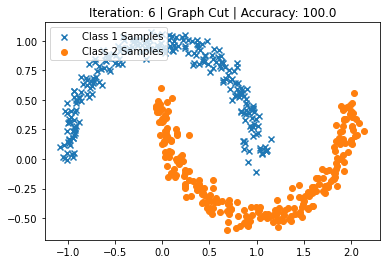


================== Iteration: 7 ==================



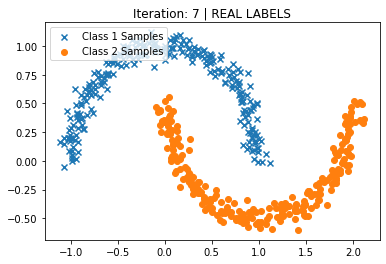

-----------------------------------------------
Cut node: 260, weight: 0.30661267042160034, vertices [260, 244, 324, 372, 488, 265, 106, 258, 405, 274, 401, 454, 495, 239, 337, 498, 236, 78, 108, 148, 55, 353, 411, 166, 279, 340, 472, 409, 158, 318, 282, 190, 79, 117, 20, 48, 197, 400, 264, 164, 465, 452, 336, 67, 128, 351, 343, 208, 361, 440, 261, 38, 130, 289, 172, 109, 155, 300, 246, 295, 161, 163, 393, 433, 430, 425, 144, 366, 26, 267, 396, 82, 134, 193, 380, 470, 150, 304, 441, 34, 131, 316, 22, 240, 410, 205, 43, 418, 227, 170, 3, 220, 308, 68, 138, 373, 30, 275, 473, 284, 424, 145, 332, 60, 94, 422, 458, 96, 362, 17, 93, 140, 218, 333, 88, 450, 243, 146, 92, 126, 391, 83, 287, 219, 215, 101, 249, 143, 321, 204, 291, 11, 121, 228, 0, 97, 483, 36, 477, 271, 59, 354, 141, 242, 213, 237, 124, 437, 147, 40, 91, 226, 114, 234, 383, 103, 494, 187, 363, 398, 200, 283, 23, 194, 290, 223, 388, 296, 374, 497, 232, 250, 230, 327, 479, 365, 326, 397, 64, 198, 89, 105, 25, 490, 341, 86, 102, 

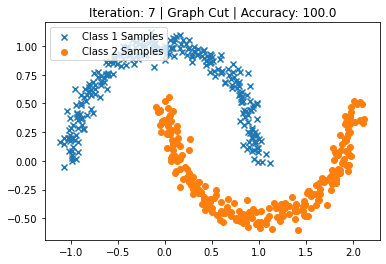


================== Iteration: 8 ==================



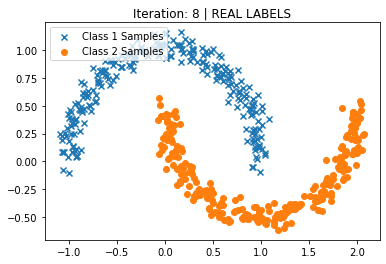

-----------------------------------------------
Cut node: 455, weight: 0.29763466119766235, vertices [455, 85, 175, 490, 83, 139, 122, 310, 260, 333, 1, 146, 244, 250, 31, 228, 28, 283, 383, 363, 428, 236, 102, 308, 297, 463, 253, 438, 477, 366, 380, 0, 307, 435, 276, 4, 170, 398, 230, 127, 95, 300, 56, 431, 461, 41, 138, 6, 413, 329, 184, 177, 469, 19, 114, 159, 74, 75, 68, 153, 167, 311, 257, 298, 320, 180, 24, 336, 353, 410, 25, 82, 10, 377, 201, 239, 62, 199, 355, 411, 429, 473, 354, 209, 155, 54, 249, 296, 124, 347, 232, 350, 421, 392, 136, 275, 425, 419, 9, 67, 449, 227, 39, 61, 317, 348, 323, 280, 423, 171, 193, 104, 452, 448, 86, 121, 459, 262, 293, 251, 497, 375, 226, 462, 98, 286, 475, 390, 360, 204, 445, 17, 196, 15, 59, 132, 369, 496, 290, 441, 388, 107, 391, 379, 334, 338, 273, 63, 432, 35, 351, 312, 376, 389, 118, 443, 480, 279, 416, 115, 282, 125, 49, 476, 365, 110, 424, 64, 342, 357, 46, 364, 186, 395, 291, 285, 417, 89, 129, 211, 14, 148, 205, 254, 198, 288, 231, 216, 

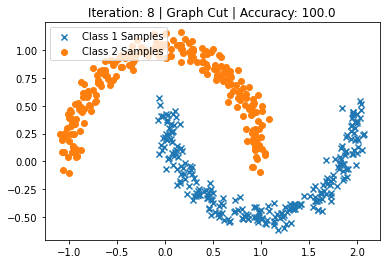


================== Iteration: 9 ==================



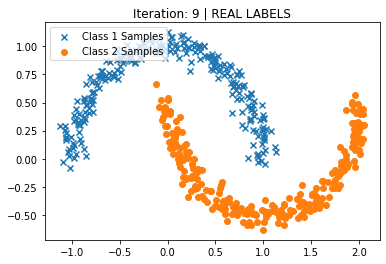

-----------------------------------------------
Cut node: 391, weight: 0.25321638584136963, vertices [391, 250, 358, 21, 82, 472, 453, 181, 209, 323, 462, 457, 273, 172, 124, 111, 272, 83, 80, 5, 47, 246, 40, 62, 184, 193, 6, 137, 202, 285, 0, 489, 41, 53, 492, 73, 183, 149, 411, 283, 295, 232, 210, 66, 441, 3, 37, 477, 56, 263, 93, 45, 382, 218, 84, 92, 448, 49, 132, 102, 155, 268, 118, 259, 307, 456, 458, 174, 426, 315, 188, 204, 361, 86, 145, 331, 256, 497, 50, 467, 438, 484, 305, 108, 419, 407, 412, 195, 332, 404, 241, 455, 475, 469, 58, 231, 287, 396, 292, 214, 177, 431, 490, 76, 488, 167, 388, 126, 215, 377, 368, 390, 175, 75, 253, 345, 270, 486, 346, 311, 130, 357, 158, 213, 200, 366, 491, 156, 95, 302, 235, 403, 192, 463, 314, 313, 72, 354, 251, 379, 229, 64, 44, 493, 310, 59, 416, 114, 398, 34, 160, 105, 429, 365, 30, 43, 367, 61, 17, 242, 88, 440, 161, 349, 468, 94, 131, 67, 186, 208, 68, 288, 163, 405, 221, 87, 252, 342, 386, 450, 439, 182, 109, 290, 154, 444, 498, 298, 258,

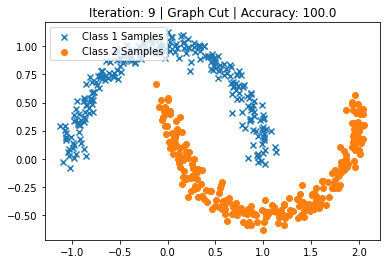


================== Iteration: 10 ==================



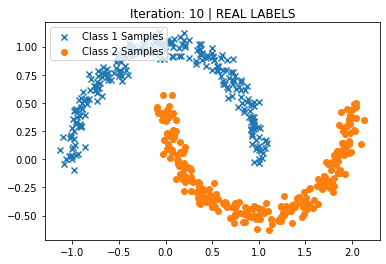

-----------------------------------------------
Cut node: 489, weight: 0.31865209341049194, vertices [489, 400, 332, 483, 152, 235, 361, 410, 268, 285, 292, 104, 341, 73, 191, 142, 266, 265, 89, 65, 460, 300, 223, 463, 218, 259, 245, 59, 115, 340, 177, 436, 263, 76, 474, 63, 498, 430, 153, 93, 415, 468, 25, 176, 124, 121, 494, 437, 355, 128, 173, 435, 336, 452, 402, 297, 439, 420, 258, 453, 111, 211, 2, 27, 81, 246, 480, 185, 497, 491, 294, 47, 165, 287, 168, 407, 305, 322, 155, 370, 351, 380, 23, 34, 248, 131, 488, 57, 102, 189, 359, 362, 108, 151, 0, 417, 311, 230, 139, 208, 431, 424, 160, 275, 399, 434, 119, 477, 309, 330, 289, 398, 214, 326, 6, 299, 457, 19, 164, 334, 409, 298, 37, 315, 342, 304, 374, 186, 320, 478, 360, 88, 242, 469, 146, 36, 485, 414, 393, 183, 229, 96, 416, 261, 314, 371, 319, 217, 442, 397, 171, 126, 329, 204, 465, 354, 12, 456, 188, 290, 143, 118, 216, 220, 32, 472, 450, 172, 284, 207, 347, 14, 106, 262, 335, 103, 213, 476, 244, 379, 79, 236, 62, 270, 16, 421,

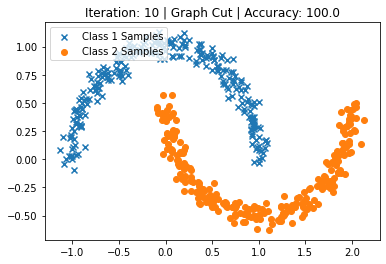

\Graph Cut Algorithm
== Accuracy ==
Std: 0.0
Mean: 100.0
== Time ==
Std: 0.146
Mean: 3.747


In [ ]:
# Number of iterations
iterations = 10

# To save accuraccies
accuracies = torch.zeros(2, iterations)

# To save times
times = torch.zeros(2, iterations)

for iteration in range(iterations):
  print(f'\n================== Iteration: {iteration + 1} ==================\n')
  
  # Create Data
  # TargetsAll, SamplesAll = createData(numberSamplesPerClass = 100, mean1 = [5,5], mean2 = [10, 10], stds1 = [5, 5, 4.2, 4.2], stds2 = [6, 6, -5, -5])
  x, y = make_moons(n_samples= 500, noise= 0.06)
  TargetsAll = torch.tensor(y, dtype=torch.float)
  SamplesAll = torch.tensor(x, dtype=torch.float).T 

  # Plot real data
  plotSampleData(SamplesAll, TargetsAll, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | REAL LABELS")

  # Train Minimum spanning tree with Graph Cut
  start_time = time.time()
  model = train_graph(SamplesAll)
  times[0][iteration] = time.time() - start_time
  print("-----------------------------------------------")
  # Calc Accuracy
  predicted_labels = predict_graph(model)
  accuracies[0][iteration] = test_graph_cut(predicted_labels, TargetsAll)

  # Plot Predicted Labels
  plotSampleData(SamplesAll, predicted_labels, show_separated=True, show_plot=True, title=f"Iteration: {iteration + 1} | Graph Cut | Accuracy: {accuracies[0][iteration]}")
  

print("\Graph Cut Algorithm")
print("== Accuracy ==")
print("Std:", round(accuracies[0].std().item(), 3))
print("Mean:", round(accuracies[0].mean().item(), 3))

print("== Time ==")
print("Std:", round(times[0].std().item(), 3))
print("Mean:", round(times[0].mean().item(), 3))
